# FEMで利用するMesh生成関数を作成する

## パッケージのロード

In [1]:
<<NDSolve`FEM`;

## テスト領域の生成

-Graphics--Graphics3D--Graphics-
-Graphics-
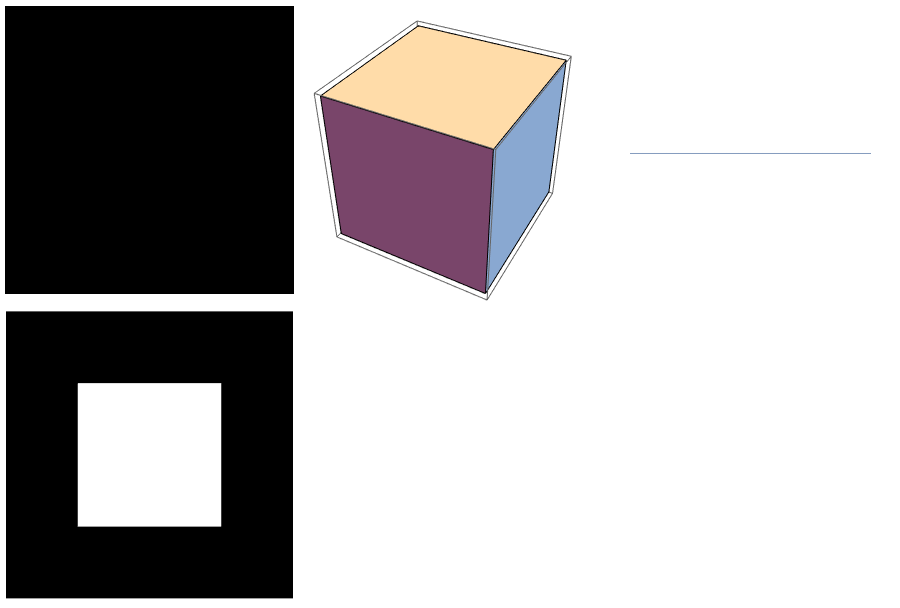

In [2]:
bar = ImplicitRegion[-1/2 <= x <= 1/2,{x}];
rectangle = Rectangle[{-1/2, -1/2}];
cuboid = Cuboid[{-1/2, -1/2, -1/2}];
rectangleWithHole = RegionDifference[Rectangle[{-1/2,-1/2}], Rectangle[{-1/4,-1/4},{1/4,1/4}]];

Column[{
    Row[{
        Graphics[rectangle, ImageSize -> #],
        Graphics3D[cuboid, ImageSize -> #],
        Show[Region[bar], ImageSize -> #]}],
    Row[{Graphics[rectangleWithHole, ImageSize -> #]}]
}]&[300]

## 関数作成

まずは基本から。

-Graphics--Graphics3D--Graphics-
-Graphics-
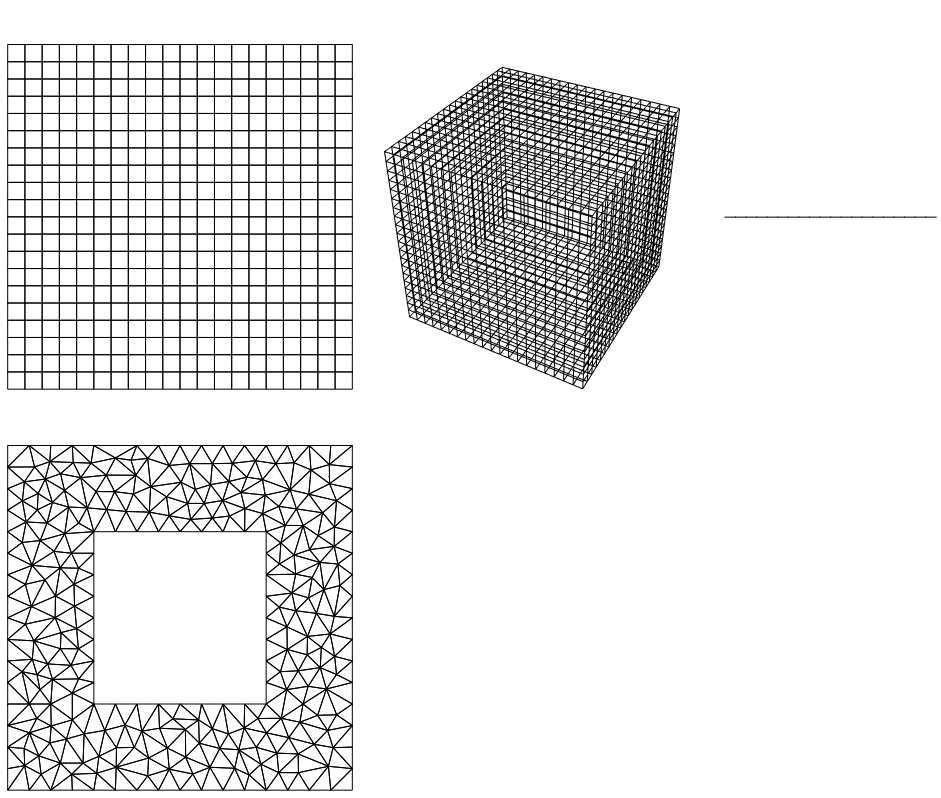

In [7]:
generateFemMesh[region_] :=
    ToElementMesh[region];

Column[{
    Row[Show[generateFemMesh[#]["Wireframe"], ImageSize->Medium]&/@{rectangle, cuboid, bar}],
    Row[Show[generateFemMesh[#]["Wireframe"], ImageSize->Medium]&/@{rectangleWithHole}]
}]

`ToElementMesh`の以下のオプションを追加で指定する。
なお`MaxBoundaryCellMeasure`と`MaxCellMeasure`の各値が同時に指定されている場合は一番厳しい設定となる。
- MeshOrder: メッシュの次数
- MeshElementType: メッシュの種類(TriangleElement, QuadElement, TetrahedronElement, HexahedronElement)
- NodeReordering: ノード番号の付け替え
- MeshQualityGoal: メッシュ要素の品質目標
- MaxBoundaryMeasure: 領域境界のセルを構成する線分の長さの最大値
- MaxCellMeasure: 以下の値の最大値
    - Length: セルを構成する線分の長さ
    - Area: セルを構成する平面の面積
    - Volume: セルを構成する立体の体積

-Graphics--Graphics3D--Graphics-
-Graphics-
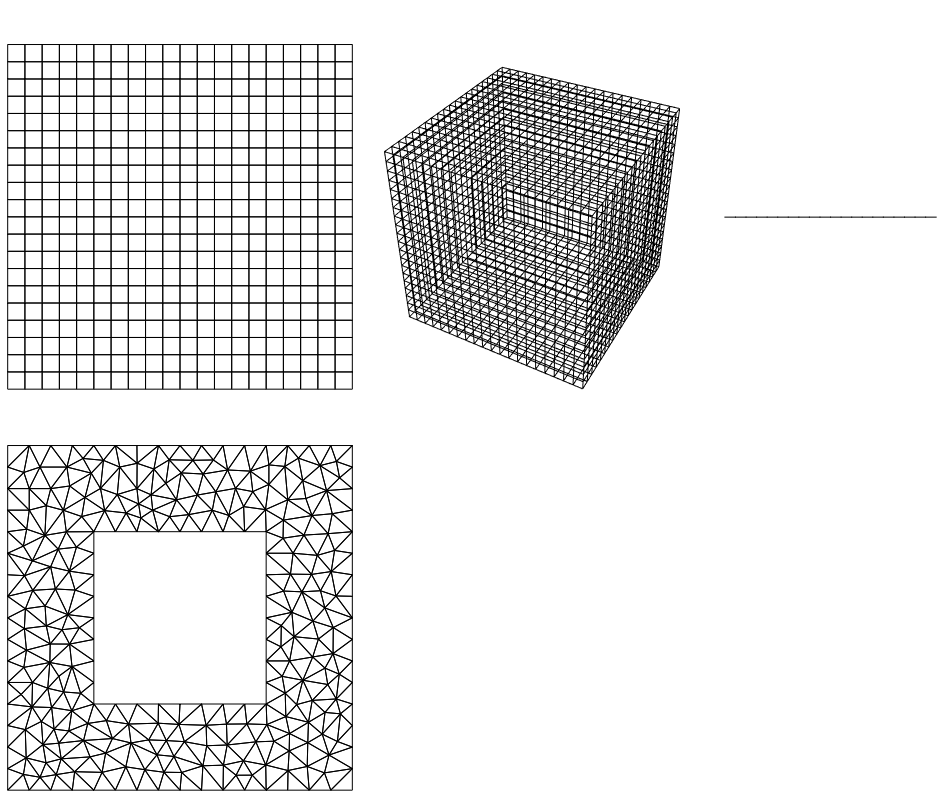

In [9]:
generateFemMesh[region_] :=
    ToElementMesh[region,
        "MeshOrder" -> 1,
        "MeshElementType" -> Automatic,
        "NodeReordering" -> True,
        MeshQualityGoal -> "Maximal",
        "MaxBoundaryCellMeasure" -> Automatic,
        "MaxCellMeasure" -> {"Length" -> Automatic, "Area" -> Automatic, "Volume" -> Automatic}];

Column[{
    Row[Show[generateFemMesh[#]["Wireframe"], ImageSize->Medium]&/@{rectangle, cuboid, bar}],
    Row[Show[generateFemMesh[#]["Wireframe"], ImageSize->Medium]&/@{rectangleWithHole}]
}]

`ToElementMesh`のオプションを自前の関数でもオプションとして指定したい。そのために`OptionsPattern`と`OptionValue`を使う。

-Graphics--Graphics3D--Graphics-
-Graphics-
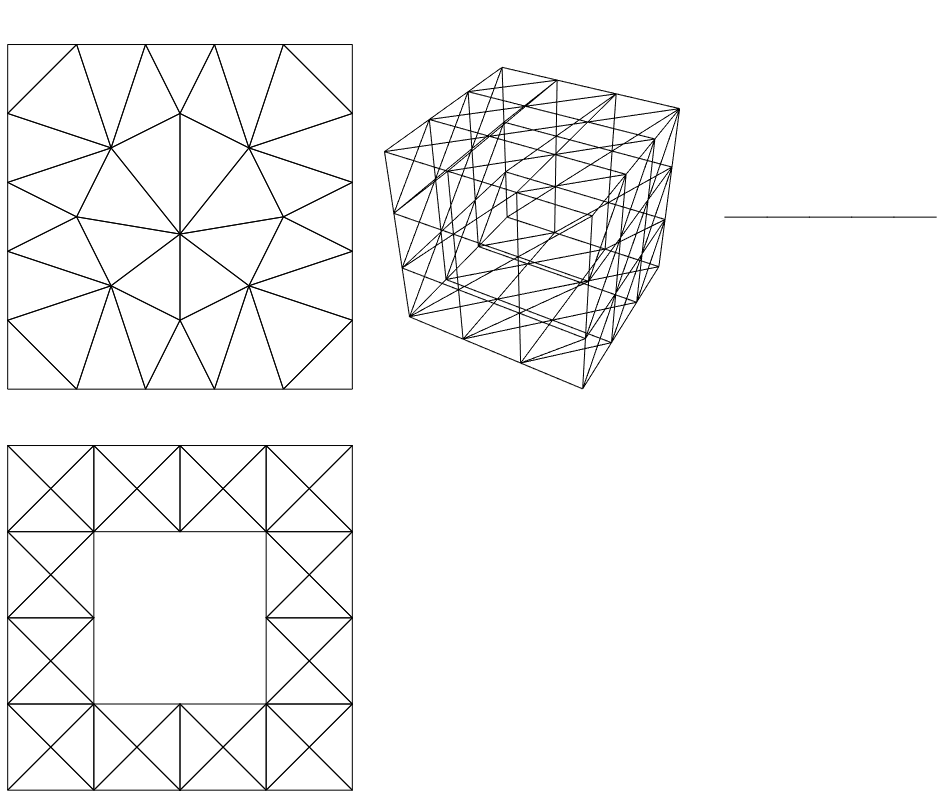

In [11]:
generateFemMesh[region_,
    OptionsPattern[{meshType -> Automatic, bcLength -> Automatic,
        length -> Automatic, area -> Automatic, volume -> Automatic}]] :=
            ToElementMesh[region,
                "MeshOrder" -> 1,
                "MeshElementType" -> OptionValue[meshType],
                "NodeReordering" -> True,
                MeshQualityGoal -> "Maximal",
                "MaxBoundaryCellMeasure" -> OptionValue[bcLength],
                "MaxCellMeasure" -> {"Length" -> OptionValue[length],
                    "Area" -> OptionValue[area], "Volume" -> OptionValue[volume]}];

meshRectangle = generateFemMesh[rectangle, meshType-> TriangleElement, area -> 0.05];
meshCuboid = generateFemMesh[cuboid, volume -> 0.05, meshType -> TetrahedronElement];
meshBar = generateFemMesh[bar, length -> 0.2];
meshRectangleWithHole = generateFemMesh[rectangleWithHole, area -> 0.03];

Column[{
    Row[Show[#["Wireframe"], ImageSize->Medium]&/@{
        meshRectangle, meshCuboid, meshBar}],
    Row[Show[#["Wireframe"], ImageSize->Medium]&/@{meshRectangleWithHole}]
}]

今の`generateFemMesh`関数では領域内部の点にはマーカーが付与されていない。`PointElements`を確認すると境界領域の点についての情報しか出てこないのがわかる。

{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {19}, {22}, {23}, {29}}, 
 
>    {4, 4, 3, 3, 1, 4, 1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 1, 4, 3, 4}]}
{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, 
 
>     {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, 
 
>     {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, 
 
>     {53}, {54}, {55}, {57}}, {2, 4, 4, 2, 2, 1, 1, 1, 1, 4, 4, 5, 4, 3, 5, 3, 5, 5, 4, 
 
>     4, 4, 4, 2, 6, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 2, 2, 6, 6, 6, 4, 1, 3, 3, 4, 2, 1, 
 
>     4, 1, 4, 2, 4, 4, 1, 5, 4, 5}]}
{PointElement[{{1}, {6}}, {1, 2}]}
{PointElement[{{1}, {3}, {6}, {8}, {11}, {13}, {15}, {17}, {20}, {21}, {22}, {23}, {24}, 
 
>     {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {36}}, 
 
>    {3, 3, 2, 2, 1, 1, 1, 4, 5, 1, 1, 6, 6, 2, 2, 7, 7, 3, 3, 8, 4, 5, 4, 5}]}
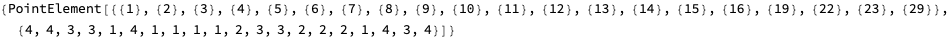
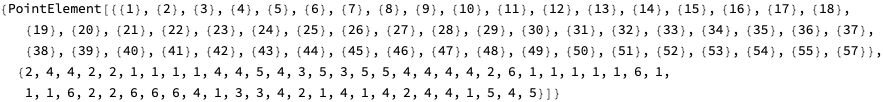
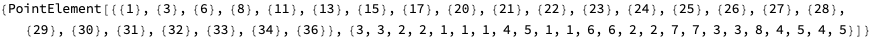

In [17]:
meshRectangle["PointElements"]
meshCuboid["PointElements"]
meshBar["PointElements"]
meshRectangleWithHole["PointElements"]

視覚的に確認するためにノード番号を青、点マーカーを赤で表示する関数を定義する（この関数は[Wolfram言語&システム ドキュメントセンターのToElementMeshのページ](https://reference.wolfram.com/language/FEMDocumentation/ref/ToElementMesh.html.ja?source=footer)の「例題>スコープ>点マーカー」に記載されている。

In [21]:
showPointMarkers[mesh_] :=
    Show[
        mesh["Wireframe"],
        mesh["Wireframe"["MeshElement" -> "PointElements", 
            "MeshElementMarkerStyle" -> Red]],
        mesh["Wireframe"["MeshElement" -> "PointElements", 
            "MeshElementStyle" -> Directive[PointSize[0.02]],
            "MeshElementIDStyle" -> Blue]]]

確認。

-Graphics--Graphics3D--Graphics-
-Graphics-
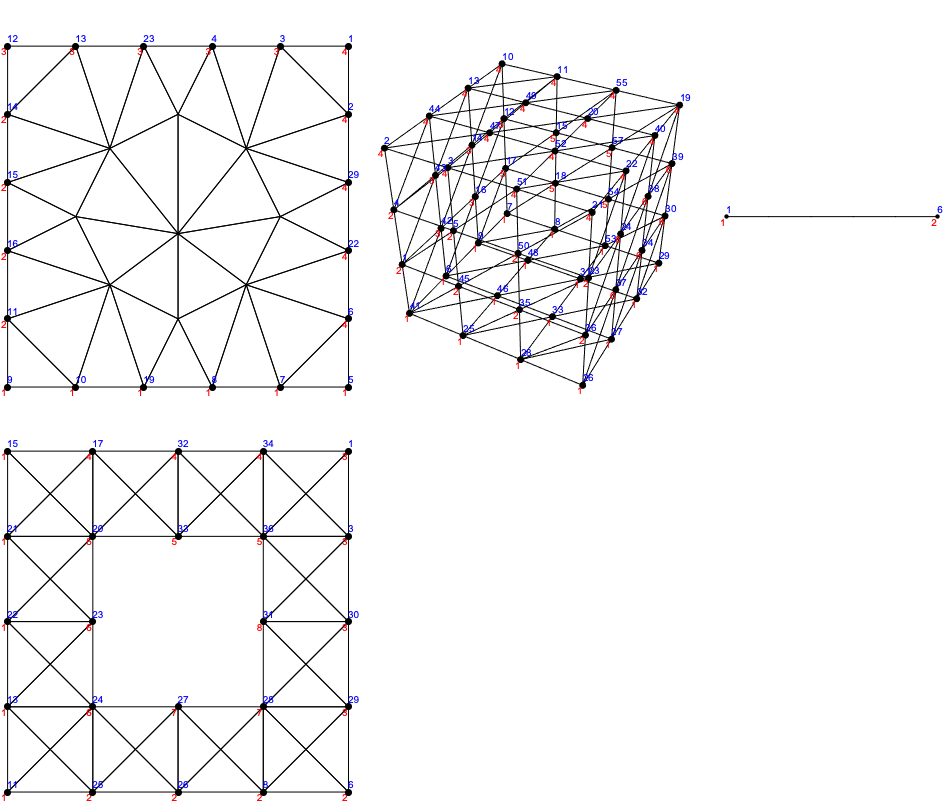

In [22]:
Column[{
    Row[Show[showPointMarkers[#], ImageSize -> Medium]&/@{
        meshRectangle, meshCuboid, meshBar}],
    Row[Show[showPointMarkers[#], ImageSize -> Medium]&/@{meshRectangleWithHole}]
}]

メッシュ内の全ての点にマーカーを付与するために座標リストを引数にとし、その点のマーカーを返す関数を用意する。例として正方形領域の左右の辺にそれぞれマーカー1と2を、上下の辺に共に3を付与する関数を作成する。

In [23]:
pmFunction[coords_] :=
    If[#[[1]] == -0.5, 1,
        If[#[[1]] == 0.5, 2,
            If[Abs[#[[2]]] == 0.5, 3, 0]]]&/@coords;

すでに得られているメッシュから必要情報を抽出し、もう一度`ToElementMesh`に渡すことで目的のメッシュを作成する。このとき`pointElements`の情報を作るために先に用意した`pointMarkerFunction`を利用する。

In [24]:
coordinates = meshRectangle["Coordinates"];
elements = meshRectangle["MeshElements"];
boundaryElements = {Head[#][#[[1]]]}&[meshRectangle["BoundaryElements"][[1]]];
pointElements =
    {PointElement[Partition[Range[Length[#]],1],
        pmFunction[#]]}&[coordinates];

これらの値を`ToElementMesh`に渡して新たなメッシュを作成する。

In [28]:
meshRectangleNew = ToElementMesh["Coordinates" -> coordinates,
    "MeshElements" -> elements,
    "BoundaryElements" -> boundaryElements,
    "PointElements" -> pointElements];

領域内部の点にもマーカーが付与されているかを確認する。

{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, 
 
>     {27}, {28}, {29}}, {2, 2, 3, 3, 2, 2, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 3, 0, 0, 
 
>     2, 3, 0, 0, 0, 0, 0, 2}]}
-Graphics-
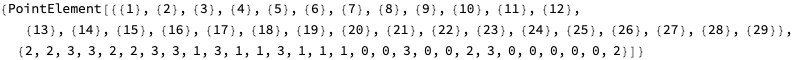
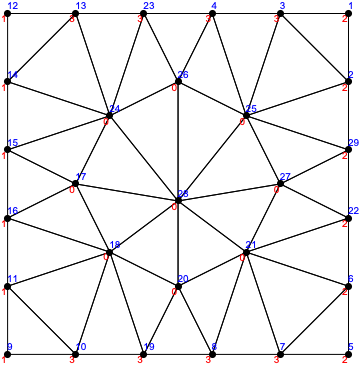

In [29]:
meshRectangleNew["PointElements"]
showPointMarkers[meshRectangleNew]

中心付近の点にマーカー4を付与した場合を確認。

{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, 
 
>     {27}, {28}, {29}}, {2, 2, 3, 3, 2, 2, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 3, 0, 0, 
 
>     2, 3, 0, 0, 0, 0, 4, 2}]}
-Graphics-
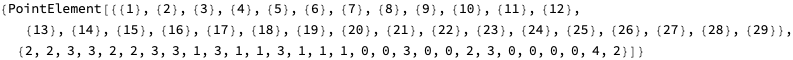
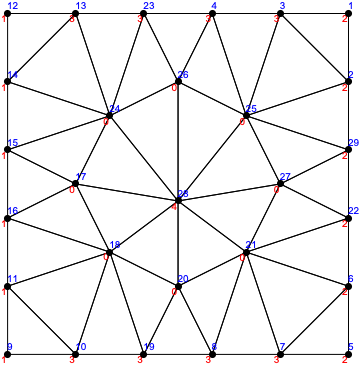

In [31]:
pmFunction[coords_] :=
    If[#[[1]] == -0.5, 1,
        If[#[[1]] == 0.5, 2,
            If[Abs[#[[2]]] == 0.5, 3,
                If[Norm[#] < 1/8, 4, 0]]]]&/@coords;
coordinates = meshRectangle["Coordinates"];
elements = meshRectangle["MeshElements"];
boundaryElements = {Head[#][#[[1]]]}&[meshRectangle["BoundaryElements"][[1]]];
pointElements =
    {PointElement[Partition[Range[Length[#]],1],
        pmFunction[#]]}&[coordinates];

meshRectangleNew2 = ToElementMesh["Coordinates" -> coordinates,
    "MeshElements" -> elements,
    "BoundaryElements" -> boundaryElements,
    "PointElements" -> pointElements];

meshRectangleNew2["PointElements"]
showPointMarkers[meshRectangleNew2]

1つのメッシュを作成するのに2段階のステップを踏むのは面倒なので、自作関数`generateFemMesh`に機能をまとめる。

In [39]:
generateFemMesh[region_, pointMarkerFunction_,
    OptionsPattern[{meshType -> Automatic, bcLength -> Automatic,
        length -> Automatic, area -> Automatic, volume -> Automatic}]] :=
            Function[mesh, ToElementMesh[
                "Coordinates" -> mesh["Coordinates"],
                "MeshElements" -> mesh["MeshElements"],
                "BoundaryElements" -> {Head[#][#[[1]]]}&[mesh["BoundaryElements"][[1]]],
                "PointElements" -> {PointElement[Partition[Range[Length[#]],1],
                    pointMarkerFunction[#]]}&[mesh["Coordinates"]]
            ]][ToElementMesh[region,
                "MeshOrder" -> 1,
                "MeshElementType" -> OptionValue[meshType],
                "NodeReordering" -> True,
                MeshQualityGoal -> "Maximal",
                "MaxBoundaryCellMeasure" -> OptionValue[bcLength],
                "MaxCellMeasure" -> {"Length" -> OptionValue[length],
                    "Area" -> OptionValue[area], "Volume" -> OptionValue[volume]}]
            ]

確認。

-Graphics--Graphics3D--Graphics-
-Graphics-
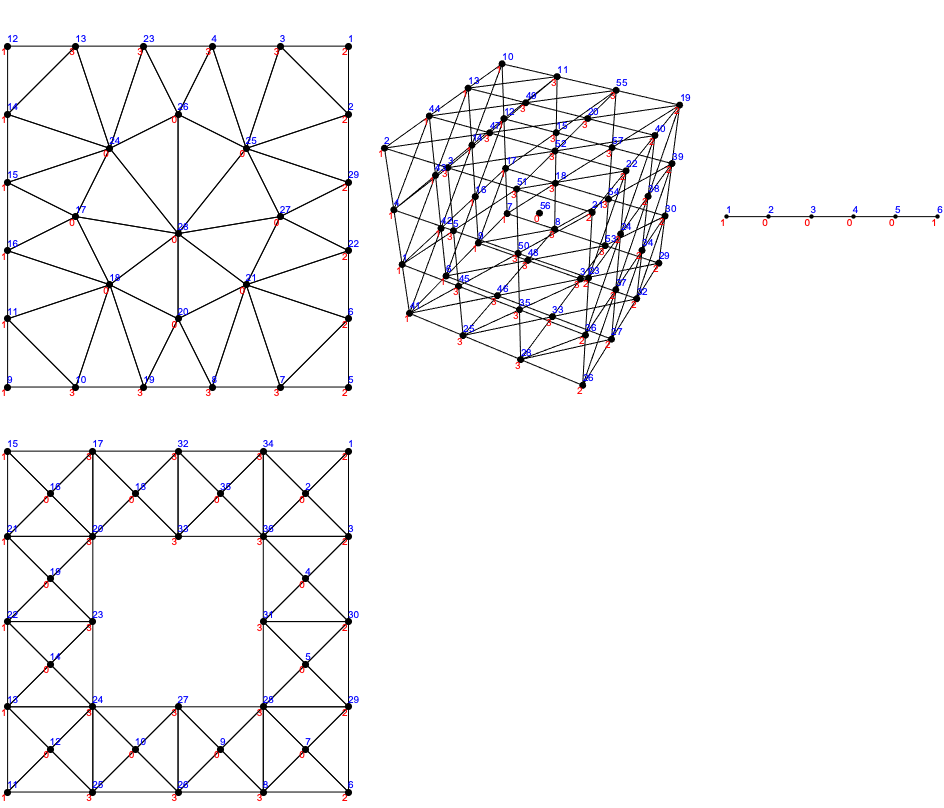

In [40]:
pmFunctionRectangle[coords_] :=
    If[#[[1]] == -0.5, 1,
        If[#[[1]] == 0.5, 2,
            If[Abs[#[[2]]] == 0.5, 3, 0]]]&/@coords;
pmFunctionCuboid[coords_] :=
    If[#[[1]] == -0.5, 1,
        If[#[[1]] == 0.5, 2,
            If[Abs[#[[2]]] == 0.5, 3,
                If[Abs[#[[3]]] == 0.5, 3, 0]]]]&/@coords;
pmFunctionBar[coords_] := If[Abs[#[[1]]] == 0.5, 1, 0]&/@coords;
pmFunctionRectangleWithHole[coords_] :=
    If[#[[1]] == -0.5, 1,
        If[#[[1]] == 0.5, 2,
            If[Or[
                Abs[#[[2]]] == 0.5,
                And[Abs[#[[1]]] == 0.25, Abs[#[[2]]] <= 0.25],
                And[Abs[#[[2]]] == 0.25, Abs[#[[1]]] <= 0.25]
            ], 3, 0 ]]]&/@coords;

meshRectangle = generateFemMesh[rectangle, pmFunctionRectangle, meshType -> TriangleElement, area -> 0.05];
meshCuboid = generateFemMesh[cuboid, pmFunctionCuboid, volume -> 0.1, meshType -> TetrahedronElement];
meshBar = generateFemMesh[bar, pmFunctionBar, length -> 0.2];
meshRectangleWithHole = generateFemMesh[rectangleWithHole, pmFunctionRectangleWithHole, area -> 0.03];

Column[{
    Row[Show[showPointMarkers[#], ImageSize -> Medium]&/@{
        meshRectangle, meshCuboid, meshBar}],
    Row[Show[showPointMarkers[#], ImageSize -> Medium]&/@{meshRectangleWithHole}]
}]

{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, 
 
>     {27}, {28}, {29}}, {2, 2, 3, 3, 2, 2, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 3, 0, 0, 
 
>     2, 3, 0, 0, 0, 0, 0, 2}]}
{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, 
 
>     {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, 
 
>     {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, 
 
>     {53}, {54}, {55}, {56}, {57}}, 
 
>    {1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 
 
>     3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
 
>     3, 0, 3}]}
{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}}, {1, 0, 0, 0, 0, 1}]}
{PointElement[{{1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, 
 
>     {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, 
 
>     {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}}, 
 
>    {2, 0, 2, 0, 0, 2, 0, 3, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 3, 1, 1, 3, 3, 3, 3, 3, 
 
>     3, 2, 2, 3, 3, 3, 3, 0, 3}]}
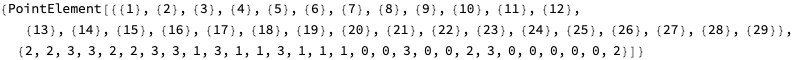
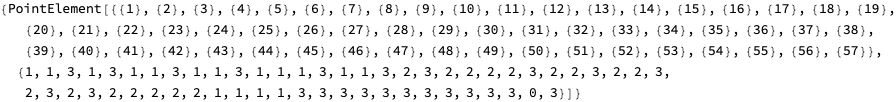
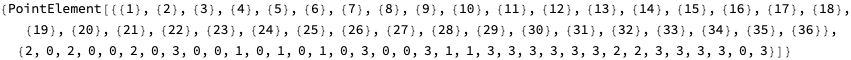

In [49]:
meshRectangle["PointElements"]
meshCuboid["PointElements"]
meshBar["PointElements"]
meshRectangleWithHole["PointElements"]

## その他便利な関数

メッシュをノード番号と要素番号付きで表示する。

In [53]:
showMeshWithId[mesh_] :=
    Show[
        mesh["Wireframe"["MeshElementIDStyle" -> Black]],
        mesh["Wireframe"["MeshElement" -> "PointElements",
            "MeshElementIDStyle" -> Blue]]]

-Graphics--Graphics3D--Graphics-
-Graphics-
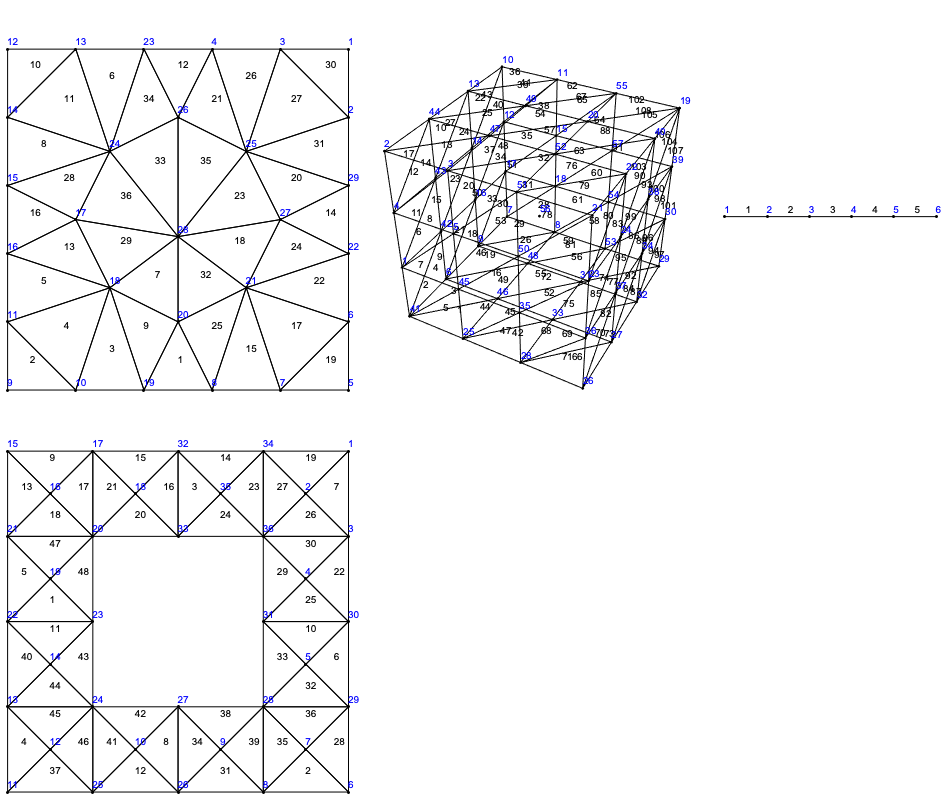

In [54]:
Column[{
    Row[Show[showMeshWithId[#], ImageSize -> Medium]&/@{
        meshRectangle, meshCuboid, meshBar}],
    Row[Show[showMeshWithId[#], ImageSize -> Medium]&/@{meshRectangleWithHole}]
}]

## ファイルへの出力

領域の名前

In [55]:
regionNameRectangle = "rectangle";
regionNameCuboid = "cuboid";
regionNameBar = "bar";
regionNameRectangleWithHole = "rectangleWithHole";

必要な情報を抽出する関数の定義

In [59]:
getDimension[mesh_] := mesh["EmbeddingDimension"];
getNumNodes[mesh_] := Length[mesh["Coordinates"]];
getNumElements[mesh_] := Length[mesh["MeshElements"][[1,1]]];
getNumNodesInEachElement[mesh_] := Length[mesh["MeshElements"][[1,1,1]]];
getNumNeighborElementsInEachElement[mesh_] := Length[mesh["ElementConnectivity"][[1,1]]];
getCoordinate[mesh_, iNode_, iAxis_] := mesh["Coordinates"][[iNode, iAxis]];
getPointMarker[mesh_, iNode_] := mesh["PointElements"][[1, 2, iNode]];
getNodeInEachElement[mesh_, iElement_, iOrder_] :=
    mesh["MeshElements"][[1, 1, iElement, iOrder]];
getNeighborElement[mesh_, iElement_, iOrder_] :=
    If[mesh["ElementConnectivity"][[1, iElement, iOrder]] == 0, -1,
        mesh["ElementConnectivity"][[1, iElement, iOrder]]];

In [68]:
getDimension/@{meshRectangle, meshCuboid, meshBar, meshRectangleWithHole}
getNumNodes/@{meshRectangle, meshCuboid, meshBar, meshRectangleWithHole}
getNumElements/@{meshRectangle, meshCuboid, meshBar, meshRectangleWithHole}
getNumNodesInEachElement/@{meshRectangle, meshCuboid, meshBar, meshRectangleWithHole}
getNumNeighborElementsInEachElement/@{meshRectangle, meshCuboid, meshBar, meshRectangleWithHole}

{2, 3, 1, 2}
{29, 57, 6, 36}
{36, 119, 5, 48}
{3, 4, 2, 3}
{3, 4, 2, 3}

ファイルへ出力する関数の定義

In [73]:
outputNodeDatas[mesh_, regionName_] :=
    (
        outStream = OpenWrite[regionName <> ".node"];
        WriteLine[outStream,
            StringRiffle[ToString/@{getNumNodes[#], getDimension[#], 0, 1}&[mesh]]]
        Do[(
            WriteLine[outStream,
                StringRiffle[ToString/@
                    Join[{#2},
                        Table[FortranForm[getCoordinate[#1, #2, iAxis]],
                            {iAxis, 1, getDimension[#1]}],
                        {getPointMarker[#1, #2]}
                    ]&[mesh, iNode]]]
        ), {iNode, 1, getNumNodes[mesh]}];
        Close[outStream];
    );

outputElementDatas[mesh_, regionName_] :=
    (
        outStream = OpenWrite[regionName <> ".ele"];
        WriteLine[outStream,
            StringRiffle[ToString/@{getNumElements[#], getNumNodesInEachElement[#], 0}&[mesh]]];
        Do[(
            WriteLine[outStream, StringRiffle[ToString/@
                Join[{#2},
                    Table[getNodeInEachElement[#1, #2, iOrder],
                        {iOrder, 1, getNumNodesInEachElement[mesh]}]
                ]&[mesh, iElement]]]
        ), {iElement, 1, getNumElements[mesh]}];
        Close[outStream];
    );

outputNeighborDatas[mesh_, regionName_] :=
    (
        outStream = OpenWrite[regionName <> ".neigh"];
        WriteLine[outStream,
            StringRiffle[
                ToString/@{getNumElements[#], getNumNeighborElementsInEachElement[#]}&[mesh]]];
        Do[(
            WriteLine[outStream,
                StringRiffle[ToString/@
                    Join[{#2},
                        Table[getNeighborElement[#1, #2, iOrder],
                            {iOrder, 1, getNumNeighborElementsInEachElement[#1]}]
                    ]&[mesh, iElement]]]
        ), {iElement, 1, getNumElements[mesh]}];
        Close[outStream];
    );

outputMeshDatas[mesh_, regionName_] :=
    (
        outputNodeDatas[#1, #2];
        outputElementDatas[#1, #2];
        outputNeighborDatas[#1, #2];
    )&[mesh, regionName];


outputMeshDatas[meshRectangle, regionNameRectangle]